In [1]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss, adfuller

# Data set  analyse

<AxesSubplot:>

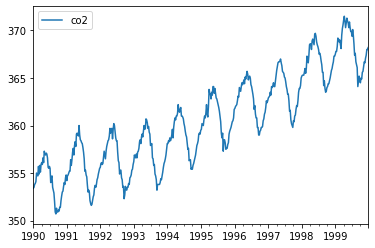

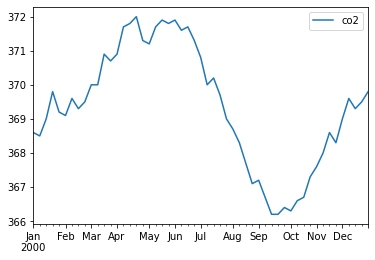

In [2]:
# On va travailler sur le jeu de données "CO2"
Data1 = sm.datasets.co2.load_pandas().data
# On garde l'année 2000 en réserve (pour la comparaison finale)
Ann2000 = Data1[ (Data1.index >= '2000') & (Data1.index < '2001') ]

# On tronque sur la période 1990-2000
Data = Data1[ (Data1.index >= '1990') & (Data1.index < '2000') ] # L'index de la série est reconnu comme l'indice temporel
Data.plot()
# On va retenir une période de 52 (une mesure par semaine sur cycle annuel)
Ann2000.plot()

In [4]:
1.indextype(Data)

pandas.core.frame.DataFrame

co2    52
dtype: int64


<AxesSubplot:>

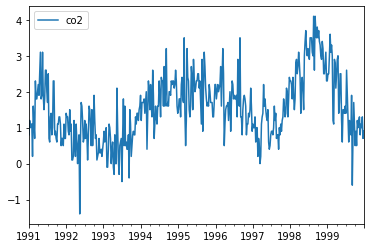

In [37]:
# On va retenir une période de 52 (une mesure par semaine sur cycle annuel)
DataDiffS = Data.diff(52) # 52 se trouve avec une Transformé de Fourier par exemple 
print(DataDiffS.isna().sum())
DataDiffS = DataDiffS.dropna() #DataDiffS différentiation sesonal
DataDiffS.plot()
# Plus de périodicité visible après une différenciation d'ordre 52


# Desompose clasique de DATA

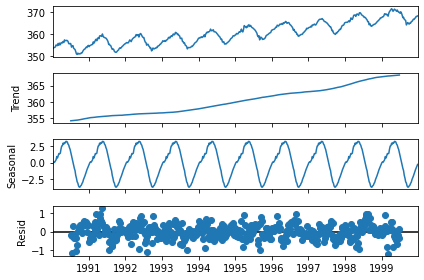

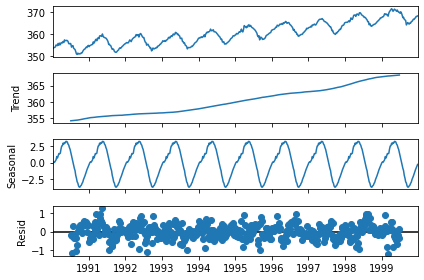

In [33]:

# Avant toute chose, faisons un simple "decompose"
Decomp = sm.tsa.seasonal_decompose(Data, model='additive', period=52) #model additif
Decomp.plot()
# Tendance linéaire assez évidente, motif périodique parfaitement retrouvé
# Accès aux éléments de la décomposition par Decomp.* avec * = trend, seasonal ou resid



<AxesSubplot:>

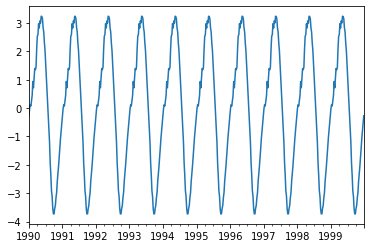

In [41]:
Decomp.seasonal.plot()

<AxesSubplot:>

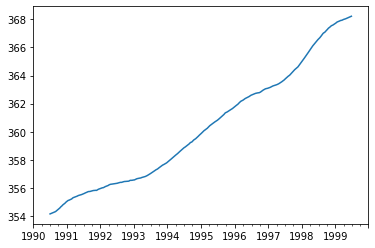

In [42]:
Decomp.trend.plot()

In [51]:
res = Decomp.resid.dropna() # Faire une analyse en mode ARMA 
TestA = adfuller(res) # Test ADF
print("ADF p-val : ", TestA[1])
TestK = kpss(res) # Test KPSS
print("KPSS p-val : ", TestK[1])
# Cette fois OK : on retient d=1 et D=1

ADF p-val :  6.062163831249092e-14
KPSS p-val :  0.1


/tmp/ipykernel_86446/1011841822.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  TestK = kpss(res) # Test KPSS


# Test de stationnarité 

In [48]:
# Testons la stationnarité après désaisonnalisation
TestA = adfuller(DataDiffS) # Test ADF non rejeté
print("ADF p-val : ", TestA)
TestK = kpss(DataDiffS) # Test KPSS
print("KPSS p-val : ", TestK)# Test rejeté
# Pas stationnaire après la différenciation saisonnière (D=1)

ADF p-val :  (-2.172472329409649, 0.21638765293688889, 8, 460, {'1%': -3.44464601455782, '5%': -2.867843681679954, '10%': -2.570127622873346}, 758.7644884306159)
KPSS p-val :  (1.008188941335768, 0.01, 12, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


/tmp/ipykernel_86446/1601175375.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  TestK = kpss(DataDiffS) # Test KPSS


# On doit redifférentier

ADF p-val :  1.3618128518100547e-22
KPSS p-val :  0.1


/tmp/ipykernel_86446/677226488.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  TestK = kpss(DataDiffS2) # Test KPSS


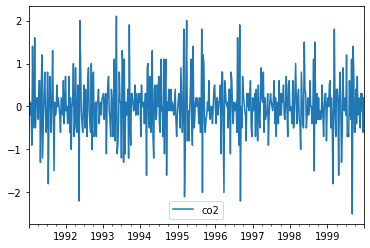

In [49]:

# On redifférencie (on passe à d=1)
DataDiffS2 = DataDiffS.diff()
DataDiffS2 = DataDiffS2.dropna()
DataDiffS2.plot()
TestA = adfuller(DataDiffS2) # Test ADF
print("ADF p-val : ", TestA[1]) #rejet la non stat
TestK = kpss(DataDiffS2) # Test KPSS
print("KPSS p-val : ", TestK[1]) # non rejet de la stat
# Cette fois OK : on retient d=1 et D=1

# ACF et PACF

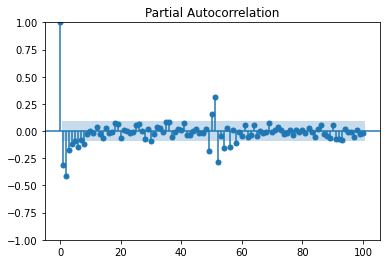

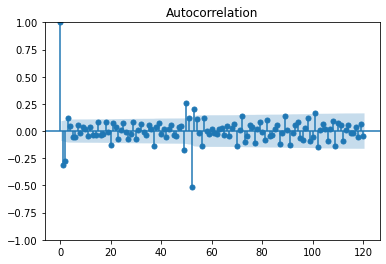

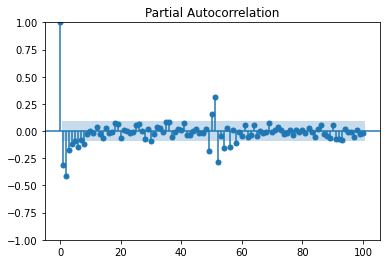

In [55]:
plot_acf(DataDiffS2, lags=120, alpha=0.05) # toute la partie périodique n'a pas été tué on peut penser à utiliser a (P,D,Q)
plot_pacf(DataDiffS2, lags=100, alpha=0.05)
# Difficile à évaluer visuellement...
# Localement : comportement ARMA
# Périodiquement : commençons par Q=1 et P=1

# Modèle SARIMA

## Model1

In [60]:
# SARIMA(2, 1, 2)x(1, 1, 1)_52 avec tendance linéaire
# Trend = 'ct' signifie constante + tendance linéaire (d'autres options sont possibles)
Mod = sm.tsa.statespace.SARIMAX(Data, order=(2, 1, 2), seasonal_order=(1, 1, 1, 52), trend='ct', enforce_stationarity=False, enforce_invertibility=False)
####    p=2,d=1,q=2,P=1,D=1,Q=1,S=52 ## c: constante, t: trend et ct:régression
ModF = Mod.fit()
# Non-singificativité dans les parties AR et MA et dans le trend


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.29626D-01    |proj g|=  7.80934D+01

At iterate    5    f=  5.27913D-01    |proj g|=  3.11444D+00

At iterate   10    f=  5.27190D-01    |proj g|=  4.76240D+01

At iterate   15    f=  4.95408D-01    |proj g|=  2.71747D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     19     29      1     0     0   1.688D-01   4.872D-01
  F =  0.48717046178698376     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FA

In [62]:
print(ModF.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                  co2   No. Observations:                  521
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 52)   Log Likelihood                -253.816
Date:                              Mon, 27 Nov 2023   AIC                            525.632
Time:                                      15:21:39   BIC                            561.843
Sample:                                  01-06-1990   HQIC                           539.953
                                       - 12-25-1999                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0241      0.022      1.078      0.281      -0.020       0.068
drift      -6.594e-

In [63]:


# On réduit les ordres AR et MA mais on garde le trend (visuellement présent...)
# SARIMA(1, 1, 1)x(1, 1, 1)_52 avec tendance linéaire
Mod = sm.tsa.statespace.SARIMAX(Data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52), trend='ct', enforce_stationarity=False, enforce_invertibility=False)
ModF = Mod.fit()
print(ModF.summary()) # Tout est très significatif, on garde ce modèle


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.48083D-01    |proj g|=  2.54080D+02

At iterate    5    f=  5.43737D-01    |proj g|=  3.47224D+00

At iterate   10    f=  5.43358D-01    |proj g|=  5.29705D+01

At iterate   15    f=  5.27334D-01    |proj g|=  5.81799D+02

At iterate   20    f=  4.88230D-01    |proj g|=  1.94794D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     20     35      1     0     0   1.948D+01   4.882D-01
  F =  0

In [59]:
print(ModF.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                co2   No. Observations:                  521
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -254.368
Date:                            Mon, 27 Nov 2023   AIC                            522.736
Time:                                    15:17:52   BIC                            550.917
Sample:                                01-06-1990   HQIC                           533.881
                                     - 12-25-1999                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0313      0.012      2.601      0.009       0.008       0.055
drift      -8.959e-05   3.68e-05   

# Superposition

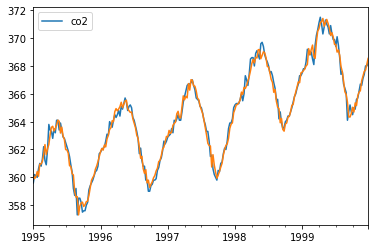

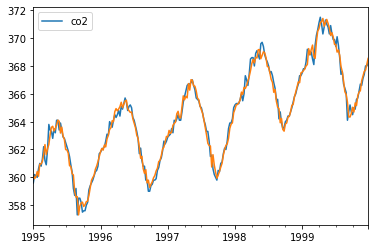

In [66]:
# Superposition des données et des fitted values à partir de 1995
Fig = Data[Data.index >= '1995'].plot()
ModF.fittedvalues[ModF.fittedvalues.index >= '1995'].plot(ax = Fig)
Fig.figure


LB p-val :  52    0.244151
Name: lb_pvalue, dtype: float64
Norm p-val :  0.0009999999999998899


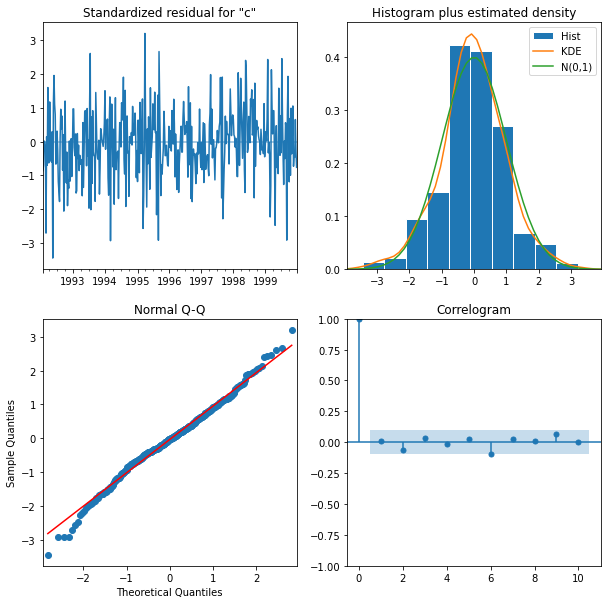

In [65]:
# Coup d'oeil sur les résidus
ModF.plot_diagnostics(figsize=(10,10))
TestLB = sm.stats.acorr_ljungbox(ModF.resid, lags=[52]) # Test de Ljung-Box au lag 52
print("LB p-val : ", TestLB["lb_pvalue"])
TestN = sm.stats.diagnostic.lilliefors(ModF.resid) # Test de Lilliefors de normalité un peu comme le test de Shapiro mais dans un autre module 
print("Norm p-val : ", TestN[1])
# Bruit blanc mais normalité douteuse

# Prédictions

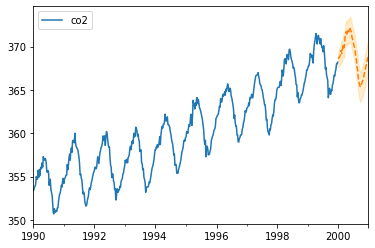

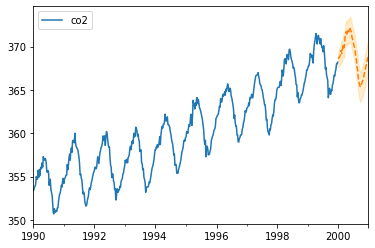

In [67]:

# Prédiction d'une année supplémentaire (avec intervalle à 99% de sécurité)
Pred = ModF.get_forecast(steps=52).summary_frame(alpha=0.05)
Fig = Data.plot()
Pred['mean'].plot(ax=Fig, style='--')
Fig.fill_between(Pred.index, Pred['mean_ci_lower'], Pred['mean_ci_upper'], color='orange', alpha=0.2)
Fig.figure

# Évaluation 

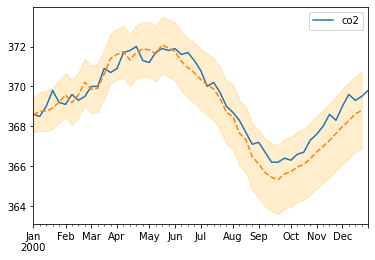

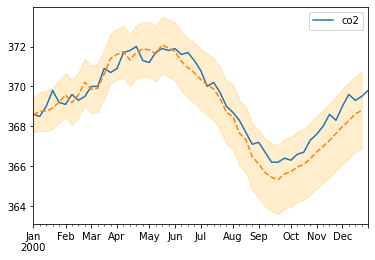

In [68]:

# Erreur entre la prédiction et l'année 2000
Fig = Ann2000.plot()
Pred['mean'].plot(ax=Fig, style='--')
Fig.fill_between(Pred.index, Pred['mean_ci_lower'], Pred['mean_ci_upper'], color='orange', alpha=0.2)
Fig.figure
# Prédiction ponctuelle qui sous-estime légèrement mais intervalle de sécurité englobant les vraies valeurs